## Registry parsing

__UNDER CONSTRUCTION__

This notebook provides an example of a simulation that takes a number of __sub_processes__, grouped in a __SequentialActivity__, that is executed in a __WhileActivity__ while a __stop condition__ is not yet met.

For this example we work with the following __sub_processes__:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
        core.Identifiable,
        core.Log,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 100
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 100,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.0004,
                 "unloading_rate": 0.0004,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes
sub_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="basic activity",
        registry=registry,
        duration=0,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
        env=my_env,
        name="sequential",
        registry=registry,
        sub_processes=sub_processes,
    )

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [8]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [9]:
plot.get_log_dataframe(vessel01, [while_activity])

Activity                  Timestamp ActivityState  container level  \
0     sailing empty 1970-01-01 00:00:00.000000         START              0.0   
1     sailing empty 1970-01-01 00:00:00.000000          STOP              0.0   
2           loading 1970-01-01 00:00:00.000000         START              0.0   
3           loading 1970-01-01 00:16:40.000000          STOP              4.0   
4      sailing full 1970-01-01 00:16:40.000000         START              4.0   
..              ...                        ...           ...              ...   
245    sailing full 1970-01-02 02:26:38.404972          STOP              4.0   
246       unloading 1970-01-02 02:26:38.404972         START              4.0   
247       unloading 1970-01-02 02:43:18.404972          STOP              0.0   
248  basic activity 1970-01-02 02:43:18.404972         START              0.0   
249  basic activity 1970-01-02 02:43:18.404972          STOP              0.0   

                           geometry            type  \
0    POINT (4.18055556 52.18664444)             NaN   
1    POINT (4.18055556 52.18664444)             NaN   
2    POINT (4.18055556 52.18664444)             NaN   
3    POINT (4.18055556 52.18664444)             NaN   
4    POINT (4.18055556 52.18664444)             NaN   
..                              ...             ...   
245  POINT (4.25222222 52.11428333)             NaN   
246  POINT (4.25222222 52.11428333)             NaN   
247  POINT (4.25222222 52.11428333)             NaN   
248  POINT (4.25222222 52.11428333)  additional log   
249  POINT (4.25222222 52.11428333)  additional log   

                                      ref  
0                                     NaN  
1                                     NaN  
2                                     NaN  
3                                     NaN  
4                                     NaN  
..                                    ...  
245                                   NaN  
246                                   NaN  
247                                   NaN  
248  ff97f07b-5f01-46b1-a60a-398197a75d5f  
249  ff97f07b-5f01-46b1-a60a-398197a75d5f  

[250 rows x 7 columns]

##### 5.2 Visualise gantt charts

In [10]:
plot.get_gantt_chart([while_activity])

In [11]:
plot.get_gantt_chart([vessel01, from_site, to_site],id_map=[while_activity])

##### 5.3 Visualise container volume developments

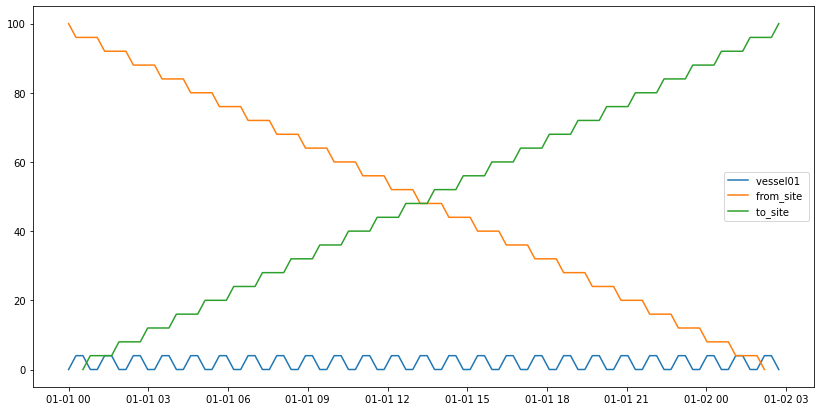

In [12]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

#### Sandbox

In [13]:
pd.DataFrame.from_dict(vessel01.log)

Timestamp                            ActivityID  \
0   1970-01-01 00:00:00.000000  dd130af7-2674-4d97-aa51-11b83dcfb184   
1   1970-01-01 00:00:00.000000  dd130af7-2674-4d97-aa51-11b83dcfb184   
2   1970-01-01 00:00:00.000000  f36f2646-60b3-45e4-9df8-6a785da43e32   
3   1970-01-01 00:16:40.000000  f36f2646-60b3-45e4-9df8-6a785da43e32   
4   1970-01-01 00:16:40.000000  ce289924-a235-4183-bc76-1c2d20ee633f   
..                         ...                                   ...   
245 1970-01-02 02:26:38.404972  ce289924-a235-4183-bc76-1c2d20ee633f   
246 1970-01-02 02:26:38.404972  0202547f-3eea-484e-8618-4e67eef45a79   
247 1970-01-02 02:43:18.404972  0202547f-3eea-484e-8618-4e67eef45a79   
248 1970-01-02 02:43:18.404972  ff97f07b-5f01-46b1-a60a-398197a75d5f   
249 1970-01-02 02:43:18.404972  ff97f07b-5f01-46b1-a60a-398197a75d5f   

    ActivityState                                        ObjectState  \
0           START  {'container level': 0.0, 'geometry': POINT (4....   
1            STOP  {'container level': 0.0, 'geometry': POINT (4....   
2           START  {'container level': 0.0, 'geometry': POINT (4....   
3            STOP  {'container level': 4.0, 'geometry': POINT (4....   
4           START  {'container level': 4.0, 'geometry': POINT (4....   
..            ...                                                ...   
245          STOP  {'container level': 4.0, 'geometry': POINT (4....   
246         START  {'container level': 4.0, 'geometry': POINT (4....   
247          STOP  {'container level': 0.0, 'geometry': POINT (4....   
248         START  {'container level': 0.0, 'geometry': POINT (4....   
249          STOP  {'container level': 0.0, 'geometry': POINT (4....   

                                         ActivityLabel  
0                                                   {}  
1                                                   {}  
2                                                   {}  
3                                                   {}  
4                                                   {}  
..                                                 ...  
245                                                 {}  
246                                                 {}  
247                                                 {}  
248  {'type': 'additional log', 'ref': 'ff97f07b-5f...  
249  {'type': 'additional log', 'ref': 'ff97f07b-5f...  

[250 rows x 5 columns]

In [14]:
list(set(vessel01.log["ActivityID"]))

['ff97f07b-5f01-46b1-a60a-398197a75d5f',
 'ce289924-a235-4183-bc76-1c2d20ee633f',
 'dd130af7-2674-4d97-aa51-11b83dcfb184',
 'f36f2646-60b3-45e4-9df8-6a785da43e32',
 '0202547f-3eea-484e-8618-4e67eef45a79']